In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import lightgbm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


Загрузим данные, используя customerID как индекс

In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (17, 6)
personal = pd.read_csv('./data/personal.csv', index_col = "customerID")
internet = pd.read_csv('./data/internet.csv', index_col = "customerID")
contract = pd.read_csv('./data/contract.csv', index_col = "customerID")
phone = pd.read_csv('./data/phone.csv', index_col = "customerID")

Посмотрим на наши датафреймы

In [3]:
print("personal \n\n", personal.info())
print("internet \n\n", internet.info())
print("contract \n\n", contract.info())
print("phone \n\n", phone.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB
personal 

 None
<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(7)
memory usage: 344.8+ KB
internet 

 None
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type

Заметим, что не все пользователи пользуются одновременно телефоном и интернетом.  
Видим, что поле TotalCharges не привелось к числовому значению, хотя по виду там только цифры. Предположим, что это в случае контракт был подписан на момент снятия данных. Проверим этот вариант.

In [4]:
try:
    contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges']) 
except ValueError:
    mask = pd.to_numeric(contract['TotalCharges'], errors='coerce').isna() 
    L = contract.loc[mask, 'BeginDate'].tolist()
    print ("Not converted dates are: " + ", ".join(L))

Not converted dates are: 2020-02-01, 2020-02-01, 2020-02-01, 2020-02-01, 2020-02-01, 2020-02-01, 2020-02-01, 2020-02-01, 2020-02-01, 2020-02-01, 2020-02-01


Так и оказалось. Заменим пустые значения на нули и приведем значения к числовому формату.

In [5]:
contract['TotalCharges'] = contract['TotalCharges'].replace(" ", 0)
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'])

Добавим новый признак isQuited для пользователей прекративших пользоваться услугами компании. В дальнейшем будем использовать его как целевой признак. Добавим это поле основываясь на значении EndDate, если указана дата - клиент считается покинувшим компанию. Удалим поля BeginDate и EndDate, они в дальнейшем нам будут не нужны. 

In [6]:
if ('EndDate' in contract.columns):
    contract["isQuited"] = (contract["EndDate"] != "No").astype(int)
    contract = contract.drop(columns = ["BeginDate", "EndDate"])
contract.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,isQuited
customerID,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0
5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1


Обратим внимание, что в колонке PaymentMethod указано либо automatic либо нет. Возможно стоит выделить отдельную колонку на то есть ли автоматическое продление или нет. Это выглядит важнее, чем какой-то конкретный вид оплаты. 

In [7]:
contract["isAutomatic"] = contract["PaymentMethod"].str.contains('automatic') == True
contract["isAutomatic"] = contract["isAutomatic"].astype(int)

Объединим наши датафреймы, но сначала проверим, что id в датафреймах phone и internet полностью содержатся в contract

In [8]:
concat_len = np.unique(np.concatenate((internet.index, phone.index), axis=None))
print(len(contract.index) == len(concat_len))

True


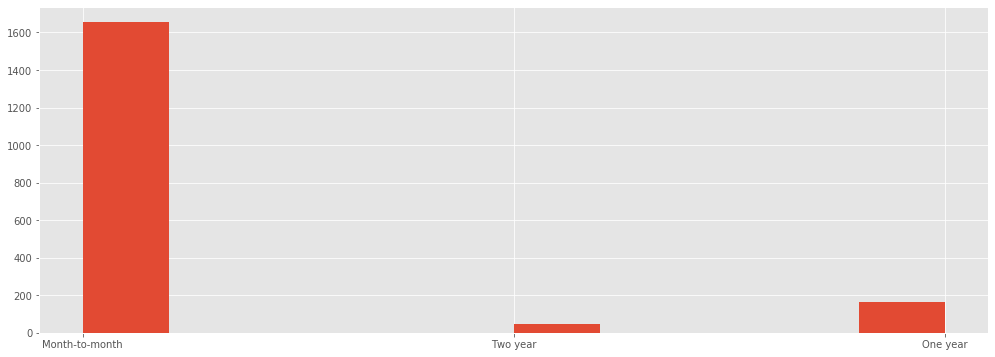

In [9]:
contract[contract["isQuited"] == 1]["Type"].hist()

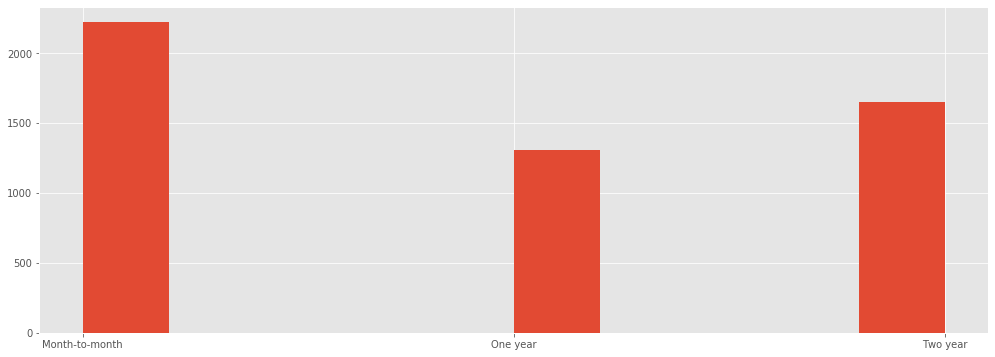

In [10]:
contract[contract["isQuited"] == 0]["Type"].hist()

In [11]:
personal

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No
...,...,...,...,...
6840-RESVB,Male,0,Yes,Yes
2234-XADUH,Female,0,Yes,Yes
4801-JZAZL,Female,0,Yes,Yes


Данные корректны, можем объединять

In [12]:
united_df = personal.join(internet).join(contract).join(phone)
#посмотрим на полученный датафрейм
united_df

,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,isQuited,isAutomatic,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,NaN
5575-GNVDE,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,0,No
3668-QPYBK,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0,No
7795-CFOCW,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,1,NaN
9237-HQITU,Female,0,No,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,0,0,Yes
2234-XADUH,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0,1,Yes
4801-JZAZL,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0,0,NaN


Добавим признаки позволяющие нам определить, есть ли у пользователя интернет и телефон. Назовем эти признаки  HaveInternet и HavePhone

C помощью LabelEncoder заменим категориальные колонки на цифровое представление. Для колонки InternetService предварительно заменим Nan значение образовавшиеся при объединения на No internet

In [13]:
united_df["InternetService"].fillna("No internet", inplace=True)
cat_cols = ["InternetService", "gender", "Type", "PaymentMethod"]
encoder = LabelEncoder()
for coll in cat_cols:
    print(coll)
    united_df[coll] = encoder.fit_transform(united_df[coll])


InternetService
gender
Type
PaymentMethod


Также стандартизируем колонки 'Yes', 'No' схожим образом. Заменим Nan на нули, Yes на 2, а No на 1

In [14]:
united_df.fillna(0, inplace=True)
united_df = united_df.replace('Yes', 1)
united_df = united_df.replace('No', 2)
united_df

,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,isQuited,isAutomatic,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,0,1,2,0,2,1,2,2,2,2,0,1,2,29.85,29.85,0,0,0
5575-GNVDE,1,0,2,2,0,1,2,1,2,2,2,1,2,3,56.95,1889.50,0,0,2
3668-QPYBK,1,0,2,2,0,1,1,2,2,2,2,0,1,3,53.85,108.15,1,0,2
7795-CFOCW,1,0,2,2,0,1,2,1,1,2,2,1,2,0,42.30,1840.75,0,1,0
9237-HQITU,0,0,2,2,1,2,2,2,2,2,2,0,1,2,70.70,151.65,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,1,0,1,1,0,1,2,1,1,1,1,1,1,3,84.80,1990.50,0,0,1
2234-XADUH,0,0,1,1,1,2,1,1,2,1,1,1,1,1,103.20,7362.90,0,1,1
4801-JZAZL,0,0,1,1,0,1,2,2,2,2,2,0,1,2,29.60,346.45,0,0,0


В полученном датафрейме много булевых значений, стандартизируем их с помощью OHE

In [15]:
united_df["SeveralInternetServices"] = (united_df["OnlineSecurity"] + united_df["OnlineBackup"] 
                                                 + united_df["DeviceProtection"] + united_df["TechSupport"] 
                                                 + united_df["StreamingTV"] + united_df["StreamingMovies"]) > 3
united_df["SeveralInternetServices"] = united_df["SeveralInternetServices"].astype(int)
united_df["SeveralInternetServices"].value_counts()

1    5517
0    1526
Name: SeveralInternetServices, dtype: int64

In [16]:
united_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
gender                     7043 non-null int64
SeniorCitizen              7043 non-null int64
Partner                    7043 non-null int64
Dependents                 7043 non-null int64
InternetService            7043 non-null int64
OnlineSecurity             7043 non-null int64
OnlineBackup               7043 non-null int64
DeviceProtection           7043 non-null int64
TechSupport                7043 non-null int64
StreamingTV                7043 non-null int64
StreamingMovies            7043 non-null int64
Type                       7043 non-null int64
PaperlessBilling           7043 non-null int64
PaymentMethod              7043 non-null int64
MonthlyCharges             7043 non-null float64
TotalCharges               7043 non-null float64
isQuited                   7043 non-null int64
isAutomatic                7043 non-null int64
MultipleLines              7043 n

Все хорошо, но у нас слишком много колонок, которые могут оказаться нерелевантными в обучении. Попробуем вычислить, от каких колонок следует избавится.  
Для этого используем колонку isQuited

In [17]:
# получим датафрейм состоящий только из клиентов покинувших оператора и постараемся найти выдающиеся на фоне основного датафрейма поля
df_quited = united_df[united_df["isQuited"] == 1]
#получим среднее по каждой колонке 
quited_mean = df_quited.describe().T["mean"]
all_df = united_df.describe().T["mean"]
#получим отношение колонок из quited к полуному значению
related =  all_df / quited_mean
# пометим как True колонки в датафрейме df_quited которые хотябы на 15% отличаются от оригинального датафрейма
important_columns = abs(related - 1) > 0.12
# Отобразим полученные колонки
important_columns

gender                     False
SeniorCitizen               True
Partner                    False
Dependents                 False
InternetService            False
OnlineSecurity              True
OnlineBackup                True
DeviceProtection            True
TechSupport                 True
StreamingTV                 True
StreamingMovies             True
Type                        True
PaperlessBilling            True
PaymentMethod              False
MonthlyCharges              True
TotalCharges                True
isQuited                    True
isAutomatic                 True
MultipleLines              False
SeveralInternetServices     True
Name: mean, dtype: bool

In [18]:
# соберем датафрейм только с важными колонками и отобразим его
united_df_important = united_df[important_columns[important_columns == True].index]
united_df_important.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 14 columns):
SeniorCitizen              7043 non-null int64
OnlineSecurity             7043 non-null int64
OnlineBackup               7043 non-null int64
DeviceProtection           7043 non-null int64
TechSupport                7043 non-null int64
StreamingTV                7043 non-null int64
StreamingMovies            7043 non-null int64
Type                       7043 non-null int64
PaperlessBilling           7043 non-null int64
MonthlyCharges             7043 non-null float64
TotalCharges               7043 non-null float64
isQuited                   7043 non-null int64
isAutomatic                7043 non-null int64
SeveralInternetServices    7043 non-null int32
dtypes: float64(2), int32(1), int64(11)
memory usage: 1.1+ MB


In [19]:
#Сбросим ненужный более индекс и посмотрим на получившийся датафрейм
united_df_important = united_df_important.reset_index(drop = True)
united_df_important

,SeniorCitizen,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Type,PaperlessBilling,MonthlyCharges,TotalCharges,isQuited,isAutomatic,SeveralInternetServices
0,0,2,1,2,2,2,2,0,1,29.85,29.85,0,0,1
1,0,1,2,1,2,2,2,1,2,56.95,1889.50,0,0,1
2,0,1,1,2,2,2,2,0,1,53.85,108.15,1,0,1
3,0,1,2,1,1,2,2,1,2,42.30,1840.75,0,1,1
4,0,2,2,2,2,2,2,0,1,70.70,151.65,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,1,2,1,1,1,1,1,1,84.80,1990.50,0,0,1
7039,0,2,1,1,2,1,1,1,1,103.20,7362.90,0,1,1
7040,0,1,2,2,2,2,2,0,1,29.60,346.45,0,0,1
7041,1,2,2,2,2,2,2,0,1,74.40,306.60,1,0,1


С помощью StandardScaler обработаем колонку TotalCharges

In [20]:
scaler = StandardScaler()
cols = ["TotalCharges", "MonthlyCharges"]

scaled_df = scaler.fit_transform(united_df_important[cols])
scaled_df = pd.DataFrame(scaled_df, columns=cols)

united_df_important = united_df_important.drop(columns = cols, axis = 1)
united_df_important = united_df_important.merge(scaled_df, left_index=True, right_index=True, how = "left")

united_df_important

,SeniorCitizen,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Type,PaperlessBilling,isQuited,isAutomatic,SeveralInternetServices,TotalCharges,MonthlyCharges
0,0,2,1,2,2,2,2,0,1,0,0,1,-0.992611,-1.160323
1,0,1,2,1,2,2,2,1,2,0,0,1,-0.172165,-0.259629
2,0,1,1,2,2,2,2,0,1,1,0,1,-0.958066,-0.362660
3,0,1,2,1,1,2,2,1,2,0,1,1,-0.193672,-0.746535
4,0,2,2,2,2,2,2,0,1,1,0,1,-0.938874,0.197365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,1,2,1,1,1,1,1,1,0,0,1,-0.127605,0.665992
7039,0,2,1,1,2,1,1,1,1,0,1,1,2.242606,1.277533
7040,0,1,2,2,2,2,2,0,1,0,0,1,-0.852932,-1.168632
7041,1,2,2,2,2,2,2,0,1,1,0,1,-0.870513,0.320338


In [61]:
target = united_df_important["isQuited"]
features = united_df_important.drop(['isQuited'] , axis=1)

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.3, 
                                                                              random_state = 123)
features_final, features_test, target_final, target_test = train_test_split(features_test, 
                                                                              target_test, 
                                                                              test_size=0.33, 
                                                                              random_state = 123)


Определим метод для работы с ROC_AUC

In [62]:
def ROC_AUC_score(model, feature, test):
    y_pred=model.predict(feature)
    print("ROC AUC score for data", roc_auc_score(y_pred, test))

    

Создадим несколько моделей для обучения:

In [88]:
lg = LogisticRegression(C=4, solver = "liblinear")
lg.fit(features_train, target_train)
ROC_AUC_score(lg, features_test, target_test)

ROC AUC score for data 0.7351036654191172


In [89]:
estimator=RandomForestClassifier(max_depth=9, n_estimators=200, criterion='entropy')
estimator.fit(features_train, target_train)
ROC_AUC_score(estimator, features_test, target_test)

ROC AUC score for data 0.7578402067078731


In [90]:
lgbm_c = lightgbm.LGBMClassifier(learning_rate=0.003, max_depth=4, n_estimators=200)
lgbm_c.fit(features_train, target_train)
ROC_AUC_score(lgbm_c, features_test, target_test)

ROC AUC score for data 0.865021770682148


Остановим свой выбор на LGBMClassifier. Проверим нашу модель на валидационных данных 

In [91]:
ROC_AUC_score(lgbm_c, features_final, target_final)

ROC AUC score for data 0.8442809845077461
